In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.cluster import Birch, SpectralClustering

import util

## Power and Agency for Characters by Gender

We obtain power and agency by analyzing the verbs used by every character. Refer to [1] for more information.

In [3]:
# Load gender map and power and agency for characters
char_gender_map = util.read_in_character_metadata('data/cdmn_mds/movie_characters_metadata.txt')
pa_df = pd.read_csv('vmaps/pa_from_vmaps.csv', index_col=0)
pa_df['gender'] = pa_df.index.map(lambda x: char_gender_map[x])

# Drop unknown genders
pa_df = pa_df[pa_df['gender'] != '?']

In [4]:
pa_df[pa_df['verb_count'] > np.median(pa_df['verb_count'])].groupby('gender').mean().reset_index()

,gender,agency,power,verb_count,av,pv
0,f,9.982143,13.454082,31.988520,0.266105,0.395732
1,m,14.229115,17.635749,38.716216,0.314827,0.433059


In [5]:
pa_df[pa_df['verb_count'] > np.median(pa_df['verb_count'])].groupby('gender').std().reset_index()

,gender,agency,power,verb_count,av,pv
0,f,15.253070,15.747624,31.031910,0.315236,0.231065
1,m,22.701093,22.842571,43.284134,0.309832,0.232756


array([<matplotlib.axes._subplots.AxesSubplot object at 0x133546ac8>,
      dtype=object)

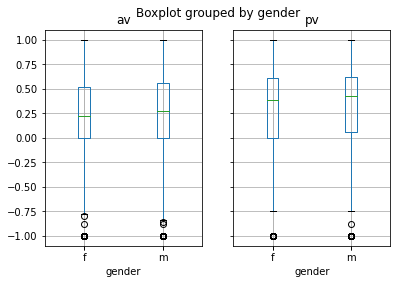

In [6]:
pa_df.boxplot(column=['av', 'pv'], by='gender')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x133529b38>,
      dtype=object)

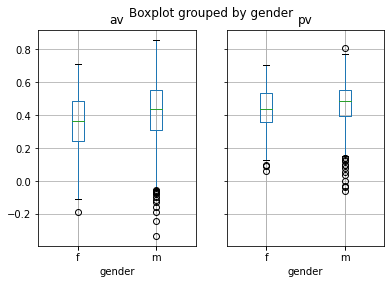

In [7]:
pa_df[pa_df['verb_count'] > np.percentile(pa_df['verb_count'], 90)].boxplot(column=['av', 'pv'], by='gender')

This clearly matches the findings of [1], where female characters tend to have lesser power and agency than their male counterparts.

## Analyzing Male-Female Character Relationships
Using the model provided by [2], we obtain a set of descriptors for each relationship span (a span may be seen as a small unit of time in the relationship). We obtain a set of probabilities for each of these descriptors for each relationship, and then analyze the relationships between characters with different genders, level of power/agency, etc. to see what kinds of descriptors are more common in such relationships. In order to explore how the power and agency of female characters manifest in the kinds of relationships they are a part of in films, we focus on relationships between one female and one male character.

In [248]:
# Get set of words closest (embedding cosine similarity) to descriptor
with open('rmn/models/descriptors.log', 'r') as f:
    desc = list(map(lambda x: x.split(' '), f.read().split('\n')))

In [249]:
# Get relationship descriptor probabilities
p, a = util.get_pa_maps('vmaps/pa_from_vmaps.csv')
traj, num_desc = util.sl_df_from_traj('rmn/models/trajectories.log', p, a)

# Get character gender info
traj['g1'] = traj['Char 1'].map(lambda x: char_gender_map[x])
traj['g2'] = traj['Char 2'].map(lambda x: char_gender_map[x])

In [250]:
# Obtain relationships with only m-f diads (no f-f, m-m)
traj_mf = traj[((traj['g1'] == 'm') & (traj['g2'] == 'f'))|((traj['g1'] == 'f') & (traj['g2'] == 'm'))].copy()

### Power and Agency Difference for Most Likely Descriptors
We obtain the most likely descriptor for each m-f relationship. For each descriptor, we check the mean values of the following quantities to see if any kind of relationship between two characters has any significant differences in power and agency between them.
$$
p_{female} - p_{male}, a_{female} - a_{male}
$$
If these values are positive, the female character has more power/agency.

In [251]:
# Get p/a difference
traj_mf['pdiff'] = traj_mf['p1'] - traj_mf['p2']
traj_mf['adiff'] = traj_mf['a1'] - traj_mf['a2']

# Fix difference order
traj_mf.loc[:, 'pdiff'] = np.where(traj_mf['g1'] == 'm', traj_mf['pdiff'] * -1, traj_mf['pdiff'])
traj_mf.loc[:, 'adiff'] = np.where(traj_mf['g1'] == 'm', traj_mf['adiff'] * -1, traj_mf['adiff'])

In [252]:
# Get most likely descriptors for each relationship
traj_x = traj_mf[['Topic {}'.format(x) for x in range(num_desc)]].values
traj_mf['mld'] = np.argmax(traj_x, axis=1)

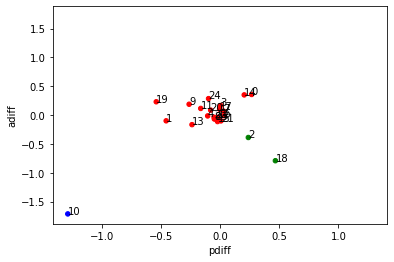

In [253]:
# For each most likely descriptor, we find the average power and agency
mld_pa_mean = traj_mf[['pdiff', 'adiff', 'mld']].groupby('mld').mean()

# Find outlying data clusters
cluster = Birch(threshold=0.05).fit(mld_pa_mean[['pdiff', 'adiff']])
colors = np.array(['red', 'blue', 'green'])
ax = mld_pa_mean.plot.scatter('pdiff', 'adiff', c=colors[cluster.labels_])
xlim = np.max(np.abs(mld_pa_mean['pdiff']))
ylim = np.max(np.abs(mld_pa_mean['adiff']))
xlim, ylim = xlim * 1.1, ylim * 1.1
ax.set_xlim([-xlim, xlim])
ax.set_ylim([-ylim, ylim])

# Annotate with descriptor ID
for d in mld_pa_mean.index:
    ax.annotate(d, (mld_pa_mean.loc[d, 'pdiff'], mld_pa_mean.loc[d, 'adiff']))

In [254]:
# Here, females have more power/agency than males
# NOTE: May have to change indices if the descriptor.log changes
print(4, desc[4])
print(18, desc[18])
print(19, desc[19])

4 ['shit', 'fuckin', 'faggots', 'kill', 'niggers', 'fucken', 'niggas', 'shits', 'fucker', 'motherfucker', 'motherfuckers', 'hate', 'fuck', 'bastards', 'nigga']
18 ['blaming', 'disgraceful', 'dishonest', 'hurting', 'apologizing', 'irresponsible', 'bitching', 'whining', 'griping', 'idiotic', 'disrespectful', 'senseless', 'insulting', 'misinformed', 'shameful']
19 ['thirty', 'ninety', 'twenty', 'hours', 'sixty', 'forty', 'hour', 'minutes', 'seconds', 'eighty', 'minute', 'elapsed', 'fifty', 'hundred', 'seventy']


In [255]:
# Here, males have more power/agency than females
# NOTE: May have to change indices if the descriptor.log changes
print(9, desc[9])
print(14, desc[14])
print(16, desc[16])

9 ['fbi', 'police', 'arrests', 'deputies', 'gunmen', 'accused', 'informants', 'embassy', 'bureau', 'telephone', 'detectives', 'impersonating', 'switchboard', 'consulate', 'eavesdropping']
14 ['grasp', 'help', 'give', 'hesitate', 'manipulate', 'intuition', 'grab', 'ability', 'instruct', 'let', 'sharpen', 'attach', 'helps', 'visualize', 'learn']
16 ['uhh', 'ouch', 'uhhh', 'jawohl', 'ahhhh', 'ummmm', 'ahh', 'duh', 'ahhh', 'ummm', 'ahhhhhh', 'uhuh', 'nope', 'nah', 'whoa']


Interestingly, descriptor 14 reflects a work-place-like relationship. This shows that films reinforce the already existing gender biases in a work enviroment. Words most cosine similar to descriptor 4 are ones relating to food; this shows that in such relationships, the female character has more power than the male, but not necessarily higher agency. Words similar to descriptor 19 suggests that relationships where the female character has significantly more power than the male character are somewhat negative.

### Descriptors Distributions and Power and Agency
Relationships are not one-dimensional. Though the most likely descriptor may be used to gather some information about them, the distribution of the probabilities for each descriptor in a relationship is more appropriate to characterize the relationship. As such, we now consider the probability distributions of the $d$ most likely descriptors. We look at the m-f relationships under consideration, and try to see if the effect of power and agency differentials on relationships has any relation with the distribution of these descriptors.

To cluster these relationships, we find the set of descriptors which are more likely than a random assignment, that is, $S_R=\{D_i: p(D_i) > \frac{1}{n_{desc}}\}$. We find the marginal distributions of these descriptors for a relationship, and set all the other descriptor probabilities for the relationship to 0. If imagined in a metric space, this would have the effect of pushing non-similar relationships further, and similar relationships closer.

In [256]:
traj_norm = traj_x.copy()
n, d = traj_norm.shape
D = 3
for i in range(n):
    rd = traj_norm[i, :]
    # Find d-D least likely descriptors and set their probabilities to 0
    lld_set = rd.argsort()[:d-D][::-1]
    rd[lld_set] = 0
# Normalize
# traj_norm[np.where(traj_norm < 1/num_desc)] = 0
traj_norm = traj_norm/np.sum(traj_norm, axis=1)[:, None]

In [257]:
# Cluster into 5 [or an appropriate number depending on D and the resultant embedding] spectral clusters
cluster = SpectralClustering(n_clusters=20).fit(traj_norm)
traj_mf['cluster'] = cluster.labels_

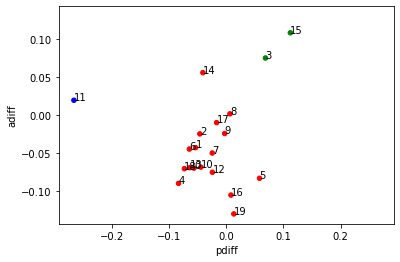

In [258]:
# For each descriptor cluster, we find the average power and agency
cl_pa_mean = traj_mf[['pdiff', 'adiff', 'cluster']].groupby('cluster').mean().reset_index()

# Find outlying data clusters
cluster = Birch(threshold=0.025).fit(cl_pa_mean[['pdiff', 'adiff']])
colors = np.array(['red', 'blue', 'green'])
ax = cl_pa_mean.plot.scatter('pdiff', 'adiff', c=colors[cluster.labels_])
xlim = np.max(np.abs(cl_pa_mean['pdiff']))
ylim = np.max(np.abs(cl_pa_mean['adiff']))
xlim, ylim = xlim * 1.1, ylim * 1.1
ax.set_xlim([-xlim, xlim])
ax.set_ylim([-ylim, ylim])

# Annotate with descriptor ID
for d in cl_pa_mean.index:
    ax.annotate(d, (cl_pa_mean.loc[d, 'pdiff'], cl_pa_mean.loc[d, 'adiff']))

In [260]:
c = 11
print(np.sum(traj_norm[traj_mf['cluster'] == c], axis=0).argsort()[-3:][::-1], len(traj_norm[traj_mf['cluster'] == c]))

[ 1 17  0] 9


In [262]:
c = 15
print(np.sum(traj_norm[traj_mf['cluster'] == c], axis=0).argsort()[-3:][::-1], len(traj_norm[traj_mf['cluster'] == c]))

[14 12 15] 25


### References
[1] Maarten Sap, Marcella Cindy Prasetio, Ariel Holtzman, Hannah Rashkin & Yejin Choi (2017). Connotation Frames of Power and Agency in Modern Films. EMNLP

[2] Iyyer, M., Guha, A., Chaturvedi, S., Boyd-Graber, J., & Daumé III, H. (2016, June). Feuding families and former friends: Unsupervised learning for dynamic fictional relationships. In Proceedings of the 2016 Conference of the North American Chapter of the Association for Computational Linguistics: Human Language Technologies (pp. 1534-1544).